In [29]:
pip install requests

**Fetch data from News API**

In [30]:
import requests
import pandas as pd

# Replace with your own API key from NewsAPI
API_KEY = 'bcf8082cc62342c2ad155e9399aa6a03'
url = 'https://newsapi.org/v2/everything'

# Fetch articles related to supply chain disruptions
params = {
    'q': 'supply chain disruption OR supplier risk OR logistics delay',
    'language': 'en',
    'pageSize': 100,
    'apiKey': API_KEY
}

response = requests.get(url, params=params)
news_data = response.json()

In [31]:
# Convert articles into a pandas DataFrame
articles = news_data['articles']
df = pd.DataFrame(articles)
df = df[['title', 'description', 'url', 'publishedAt', 'content']]

# Display the collected news data
print(df.head())

                                               title  \
0              U.S. Faces Critical IV Fluid Shortage   
1  Get ready for a dockworker strike that could d...   
2  There's already a queue of cargo ships backing...   
3  New Jersey hits pause on an offshore wind farm...   
4  East Coast Port Strikes: What Businesses Can D...   

                                         description  \
0  A major IV fluid supplier has temporarily lost...   
1  An October strike on shipping docks along the ...   
2  Ship tracking data show a growing number of ca...   
3  New Jersey has hit pause on an offshore wind e...   
4  East Coast port strikes could have a significa...   

                                                 url           publishedAt  \
0  https://gizmodo.com/u-s-faces-critical-iv-flui...  2024-10-10T15:50:19Z   
1  https://www.businessinsider.com/dockworker-str...  2024-09-24T08:29:02Z   
2  https://www.businessinsider.com/queue-of-cargo...  2024-10-03T10:00:05Z   
3  https://abc

**Data Preprocessing**

In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [34]:
# Apply text preprocessing to the news content
df['cleaned_content'] = df['content'].apply(lambda x: preprocess_text(x) if x else '')
print(df[['title', 'cleaned_content']].head())

                                               title  \
0              U.S. Faces Critical IV Fluid Shortage   
1  Get ready for a dockworker strike that could d...   
2  There's already a queue of cargo ships backing...   
3  New Jersey hits pause on an offshore wind farm...   
4  East Coast Port Strikes: What Businesses Can D...   

                                     cleaned_content  
0  slew hurricanes bombarding eastern late indire...  
1  istock rebecca ul li international longshorema...  
2  container ship facility bayonne new jersey ima...  
3  trenton new jersey hit pause button wednesday ...  
4  port standstill getty holiday season around co...  


**Named Entity Recognition (NER) with spaCy**

In [35]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [36]:
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [37]:
# Apply NER on the cleaned content
df['entities'] = df['cleaned_content'].apply(lambda x: extract_entities(x) if x else [])
print(df[['title', 'entities']].head())

                                               title  \
0              U.S. Faces Critical IV Fluid Shortage   
1  Get ready for a dockworker strike that could d...   
2  There's already a queue of cargo ships backing...   
3  New Jersey hits pause on an offshore wind farm...   
4  East Coast Port Strikes: What Businesses Can D...   

                                            entities  
0                                                 []  
1  [(li international longshoreman association, O...  
2       [(new jersey, GPE), (li, PERSON), (us, GPE)]  
3  [(new jersey, GPE), (wednesday, DATE), (jersey...  
4                                     [(year, DATE)]  


**Summarization with Pre-trained LLM**

In [38]:
pip install transformers

In [39]:
from transformers import pipeline

# Load the summarization pipeline
summarizer = pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [40]:
def summarize_text(text):
    if text:
        return summarizer(text, max_length=60, min_length=20, do_sample=False)[0]['summary_text']
    return ''

# Limit the number of articles to summarize
df_subset = df.head(20)

# Apply summarization on the cleaned content
df_subset['summary'] = df_subset['cleaned_content'].apply(summarize_text)

Your max_length is set to 60, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 60, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 60, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 60, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max

In [41]:
# Print the summary of the first few articles
print(df_subset[['title', 'summary']].head())

                                               title  \
0              U.S. Faces Critical IV Fluid Shortage   
1  Get ready for a dockworker strike that could d...   
2  There's already a queue of cargo ships backing...   
3  New Jersey hits pause on an offshore wind farm...   
4  East Coast Port Strikes: What Businesses Can D...   

                                             summary  
0   Hospitals across U.S. facing shortages iv flu...  
1   International longshoreman association strike...  
2   dockworkers strike immediate effect flow of g...  
3   trenton new jersey hit pause button wednesday...  
4   port standstill gets to port terminals around...  


**Graph Construction for Supply Chain Risk Visualization**

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph where nodes are entities (regions, suppliers)
G = nx.Graph()

# Add edges based on entities in each article
for _, row in df.iterrows():
    entities = [ent[0] for ent in row['entities'] if ent[1] in ['ORG', 'GPE']]  # Only include organizations and geopolitical entities
    for i in range(len(entities) - 1):
        G.add_edge(entities[i], entities[i + 1], weight=1)

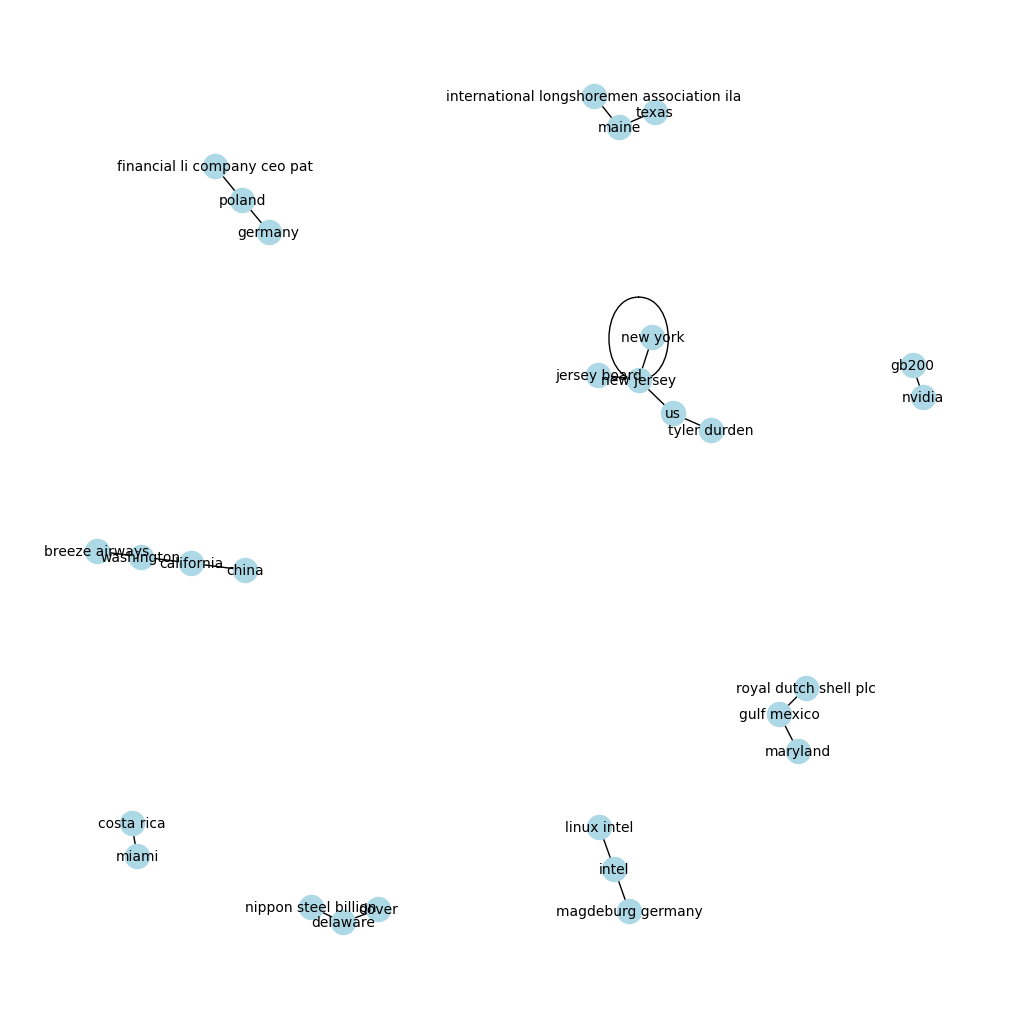

In [43]:
# Plot the graph
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color='lightblue', font_size=10)
plt.show()

**Risk Scoring and Suggestions**

In [44]:
# Create a dictionary to track entity risk scores
entity_risk = {}

# Increase risk score for each entity based on mentions
for _, row in df.iterrows():
    for entity in row['entities']:
        if entity[0] not in entity_risk:
            entity_risk[entity[0]] = 0
        entity_risk[entity[0]] += 1

# Function to suggest alternative suppliers based on risk
def suggest_alternatives(risky_entity):
    sorted_risk = sorted(entity_risk.items(), key=lambda x: x[1])
    alternatives = [ent for ent, score in sorted_risk if ent != risky_entity][:3]
    return alternatives

In [45]:
# Example usage: Suggest alternatives for a risky supplier
risky_supplier = 'SupplierA'
alternatives = suggest_alternatives(risky_supplier)
print(f"Alternatives for {risky_supplier}: {alternatives}")

Alternatives for SupplierA: ['li international longshoreman association', 'october 1', 'jersey board']
